# AutoRegressive Integrated Moving Average model [ARIMA(p,w,q)]
Using this model, we can take into account non-stationary time series and avoid the steps of modeling on differenced data and having to undifference the forecasts.



In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Defining ARIMA model
An ARIMA process is the combination of an autoregressive process AR(p), integration I(w), and the moving average process MA(q). The ARMA process, the ARIMA process states that the present value dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, the ARIMA process uses the differenced series. Therefore, the mathematical expression of the ARIMA(p,d,q) process defines that the present value of the differenced series $y'_t$ is equal to the sum of a constant C, past values of the differenced series $φ_p y'_t - p$, the mean of the differenced series μ, past error terms $θ_q ε_t - q$, and a current error term $ε_t$, as:

$y'_t = [C + (ϕ_1 y'_{t-1}) + (ϕ_2 y'_{t-2}) + ⋅⋅⋅ + (ϕ_p y'_{t-p})] + [μ + ϵ_t + θ_1 ϵ'_{t−1} + θ_2 ϵ'_{t−2} + ⋅⋅⋅ + θ_q ϵ'_{t−q}]$

Just like in the ARMA process, the order `p` determines how many `lagged values` of the series are included in the model, while the order `q` determines how many `lagged error terms` are included in the model. Here the order `w` is defined as the order of integration. The order of integration 'w' is equal to the number of times the series was differenced to be rendered stationary.

**The ARIMA model is simply an ARMA model that can be applied on `non-stationary` time series. Whereas the ARMA(p,q) model requires the series to be stationary.**

# Modifying the general modeling procedure to account for nonstationary series

## Steps for ARIMA
1. collect the data
2. check for `stationarity` (using ADF test)
    * if not stationary, then apply transformation e.g. first difference
3. check for MA process using ACF plot
    * if there are significant autocorrelation coefficients after lag 0. Therefore, it is not a `random walk`, apply MA(q)
    * if coefficients slowly decay, apply AR(p)
    * Can STOP the process
4. check for AR process using PACF plot
    * if coefficients slowly decay, apply AR(p)
    * if coefficients have sinusoidal pattern as well, apply ARMA (p,q)
    * Can STOP the process
5. set w = no. of times the series was differenced
6. fit many ARIMA(p,w,q) models with various combination of p and q.
7. select a model according to the **`Akaike’s Information Criterion (AIC)`** and assess its viability via the analysis of its `residuals`. Ideally, the residuals of a model will have similar characteristics to white noise.
8. use this model to make forecasts.




# Forecasting a non-stationary times series

In [3]:
df = pd.read_csv('Johnson&Johnson.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


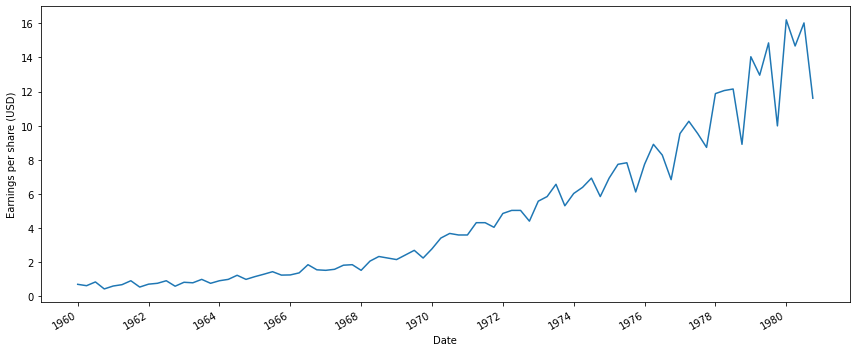

In [4]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [10]:
## Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0])) # Retrieve the ADF statistic
    print('p - value: {}'.format(result[1]))      # Retrieve the p-value
    if result[1] <= 0.05:
        print("strong evidence against the H0, reject the H0. Data has no unit root and is stationary")
    else:
        print("weak evidence against H0, time series has a unit root, indicating it is Non-stationary ")
    
    return result

ADF_result = adf_test(df.data)

ADF Statistics: 2.7420165734574766
p - value: 1.0
weak evidence against H0, time series has a unit root, indicating it is Non-stationary 


In [11]:
## Apply transformation - First difference ## To remove the effect of the trend and stabilize the mean of the series

eps_diff   = np.diff(df.data, n=1)
ADF_result = adf_test(bandwidth_diff)

ADF Statistics: -0.4074097636380511
p - value: 0.9088542416911296
weak evidence against H0, time series has a unit root, indicating it is Non-stationary 


In [12]:
## Apply transformation again

eps_diff2  = np.diff(eps_diff, n=1)
ADF_result = adf_test(eps_diff2)

ADF Statistics: -3.585162874793196
p - value: 0.00605109986960286
strong evidence against the H0, reject the H0. Data has no unit root and is stationary


In [15]:
## Obtain the order of p and q for ARMA(p,q)

ps         = range(0, 4, 1)
qs         = range(0, 4, 1)
w          = 2
order_list = list(product(ps, qs))

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, w: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], w, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    ## Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

train     = df['data'][:-4]
result_df = optimize_ARIMA(train, order_list, w)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.275907
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430620
4,"(0, 3)",194.654716
5,"(0, 2)",209.274541
6,"(2, 3)",220.666894
7,"(1, 3)",228.267769
8,"(1, 2)",228.935762
9,"(2, 2)",229.974686


In [16]:
model     = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.638
Date:                Sun, 23 Oct 2022   AIC                            115.276
Time:                        19:36:36   BIC                            131.773
Sample:                             0   HQIC                           121.880
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.037    -26.914      0.000      -1.073      -0.927
ar.L2         -0.9880      0.040    -24.933      0.000      -1.066      -0.910
ar.L3         -0.9748      0.027    -36.535      0.0

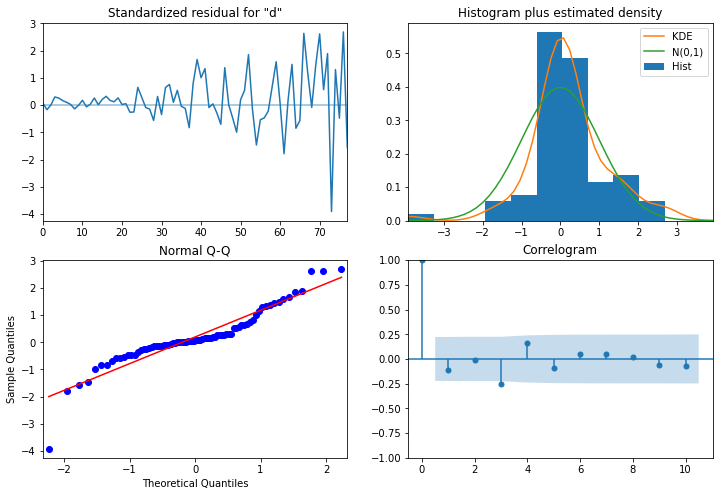

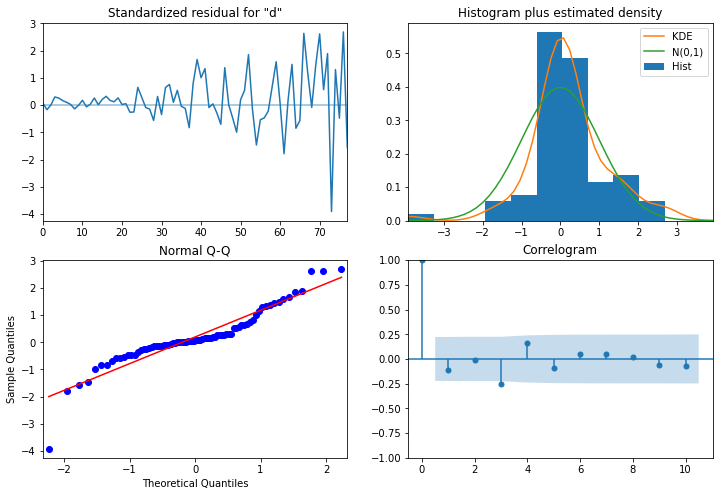

In [17]:
model_fit.plot_diagnostics(figsize=(12,8))

In [18]:
## last step is to run the Ljung-Box test on the residuals for the first 10 lags.
## If the returned p-values exceed 0.05, then we cannot reject H0,
## which means that our residuals are uncorrelated and independently distributed, just like white noise.

residuals       = model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=False)
# Apply the Ljung-Box test on the residuals, on 10 lags
print(pvalue)

## The resulting list of p-values shows that each is above 0.05.
## Therefore, at each lag, the null hypothesis (H0) cannot be rejected
## meaning that the residuals are independently distributed and uncorrelated.

[0.20437314 0.44460645 0.06281272 0.05551055 0.0798987  0.12111467
 0.17093806 0.24081944 0.29736502 0.3470568 ]


In [19]:
## As a benchmark to our model, we will use the naïve seasonal method. This means that we take the earnings per share (EPS)
## of the first quarter of 1979 and use it as a forecast for the EPS of the first quarter of 1980.
## Then, the EPS of the second quarter of 1979 is used as a forecast for the EPS of the second quarter of 1980, and so on.

test                   = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [20]:
ARIMA_pred             = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred']     = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.854319
81,1980-04-01,14.67,12.96,14.381381
82,1980-07-02,16.02,14.85,16.361827
83,1980-10-01,11.61,9.99,11.683499


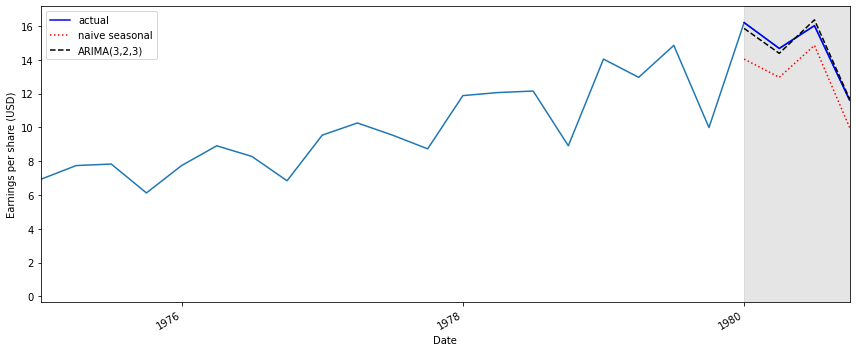

In [21]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae_naive_seasonal = mean_absolute_error(test.data, test.naive_seasonal)
mae_ARIMA          = mean_absolute_error(test.data, test.ARIMA_pred)

print(mae_naive_seasonal, mae_ARIMA)

1.6649999999999996 0.26240662593519604


In [32]:
mse_naive_seasonal = mean_squared_error(test.data, test.naive_seasonal)
mse_ARIMA          = mean_squared_error(test.data, test.ARIMA_pred)

print(mse_naive_seasonal, mse_ARIMA)

2.8957499999999987 0.08126105884397515


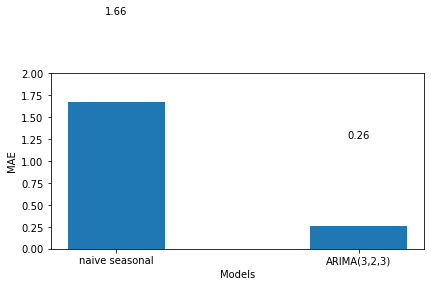

In [31]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mae_naive_seasonal, mae_ARIMA]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 2)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

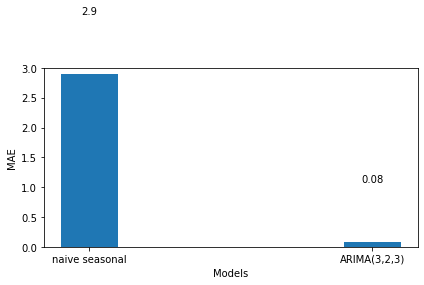

In [34]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mse_naive_seasonal, mse_ARIMA]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()